# Double Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta_1 & \dot{\theta_1} & \theta_2 & \dot{\theta_2}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0 & 0 & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.025  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 75 # Horizon length.
H = 3 * N  # Episode length.
U_MAX = torch.tensor([20.0])  # Maximum action.
U_MIN = -U_MAX  # Minimum action.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.double_cartpole.DoubleCartpoleCost()
model = pddp.examples.double_cartpole.DoubleCartpoleDynamicsModel(DT)
env = pddp.examples.double_cartpole.DoubleCartpoleEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(Z.shape[0]) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta1 = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta1_dot = X[:, 3]
    theta2 = np.unwrap(X[:, 4])  # Makes for smoother plots.
    theta2_dot = X[:, 5]
    
    plt.figure()
    plt.plot(theta1, theta1_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Link 1 Orientation Phase Plot")

    plt.figure()
    plt.plot(theta2, theta2_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Link 2 Orientation Phase Plot")
    
    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta1)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Link 1 orientation path")

    plt.figure()
    plt.plot(t, theta1_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Link 1 angular velocity path")
    
    plt.figure()
    plt.plot(t, theta2)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Link 2 orientation path")
    
    plt.figure()
    plt.plot(t, theta2_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Link 2 angular velocity path")

    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, state, Z, U, J_opt):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    final_state[4] = (final_state[4] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, state, J_opt, final_state)

In [10]:
controller = pddp.controllers.iLQRController(env, model, cost)

In [11]:
U = 1e-3 * torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
env.reset()
Z, U, state = controller.fit(U, encoding=ENCODING, n_iterations=100, tol=0,
                             on_iteration=on_iteration, u_min=U_MIN, u_max=U_MAX)

iteration 1 iLQRState.REJECTED 1233.0145 [ 0.01750934  0.01667719 -3.1342957  -0.06673545  3.1299257   0.0727147 ]
iteration 1 iLQRState.REJECTED 1233.0145 [ 0.01750934  0.01667719 -3.1342957  -0.06673545  3.1299257   0.0727147 ]
iteration 1 iLQRState.REJECTED 1233.0145 [ 0.01750934  0.01667719 -3.1342957  -0.06673545  3.1299257   0.0727147 ]
iteration 1 iLQRState.REJECTED 1233.0145 [ 0.01750934  0.01667719 -3.1342957  -0.06673545  3.1299257   0.0727147 ]
iteration 1 iLQRState.REJECTED 1233.0145 [ 0.01750934  0.01667719 -3.1342957  -0.06673545  3.1299257   0.0727147 ]
iteration 1 iLQRState.REJECTED 1233.0145 [ 0.01750934  0.01667719 -3.1342957  -0.06673545  3.1299257   0.0727147 ]
iteration 1 iLQRState.ACCEPTED 1232.1958 [ 0.01447162  0.00936808 -3.1344469  -0.03462097  3.1291835   0.02565015]
iteration 2 iLQRState.ACCEPTED 1232.015 [ 1.1285942e-02  2.8724102e-03 -3.1342928e+00 -1.4966775e-02
  3.1279516e+00  5.4185763e-03]
iteration 3 iLQRState.ACCEPTED 1231.9451 [ 9.6508339e-03 -2.86

iteration 35 iLQRState.REJECTED 816.473 [-0.17174383  0.2632076   2.2839952   0.02990073  0.33388796 -0.120464  ]
iteration 35 iLQRState.REJECTED 816.473 [-0.17174383  0.2632076   2.2839952   0.02990073  0.33388796 -0.120464  ]
iteration 35 iLQRState.ACCEPTED 816.47076 [-0.17084464  0.2637161   2.2874296   0.02868596  0.33189085 -0.12181127]
iteration 36 iLQRState.ACCEPTED 816.4674 [-0.17128122  0.2620407   2.2877696   0.03043446  0.33221826 -0.11981639]
iteration 37 iLQRState.REJECTED 816.4674 [-0.17128122  0.2620407   2.2877696   0.03043446  0.33221826 -0.11981639]
iteration 37 iLQRState.REJECTED 816.4674 [-0.17128122  0.2620407   2.2877696   0.03043446  0.33221826 -0.11981639]
iteration 37 iLQRState.ACCEPTED 816.4669 [-0.17114954  0.26195037  2.2889194   0.03023776  0.33145297 -0.12012699]
iteration 38 iLQRState.ACCEPTED 816.4666 [-0.17190757  0.2613383   2.2868664   0.03119072  0.33205402 -0.11915347]
iteration 39 iLQRState.REJECTED 816.4666 [-0.17190757  0.2613383   2.2868664   0.

iteration 68 iLQRState.REJECTED 816.46564 [-0.17151648  0.26099777  2.2892556   0.03111985  0.33103746 -0.11914155]
iteration 68 iLQRState.ACCEPTED 816.4656 [-0.17151648  0.26099777  2.2892556   0.03111985  0.33103746 -0.11914155]
iteration 69 iLQRState.REJECTED 816.46564 [-0.17151648  0.26099777  2.2892556   0.03111985  0.33103746 -0.11914155]
iteration 69 iLQRState.ACCEPTED 816.4656 [-0.17151648  0.26099777  2.2892556   0.03111985  0.33103746 -0.11914155]
iteration 70 iLQRState.REJECTED 816.46564 [-0.17151648  0.26099777  2.2892556   0.03111985  0.33103746 -0.11914155]
iteration 70 iLQRState.ACCEPTED 816.4656 [-0.17151648  0.26099777  2.2892556   0.03111985  0.33103746 -0.11914155]
iteration 71 iLQRState.REJECTED 816.46564 [-0.17151648  0.26099777  2.2892556   0.03111985  0.33103746 -0.11914155]
iteration 71 iLQRState.ACCEPTED 816.4656 [-0.17151648  0.26099777  2.2892556   0.03111985  0.33103746 -0.11914155]
iteration 72 iLQRState.REJECTED 816.46564 [-0.17151648  0.26099777  2.289255

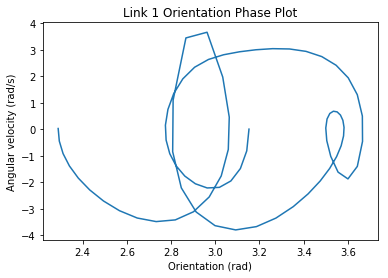

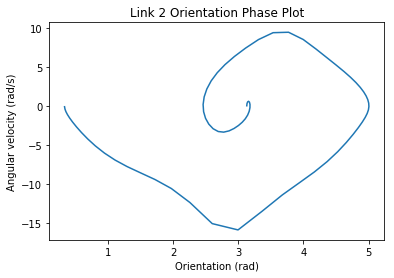

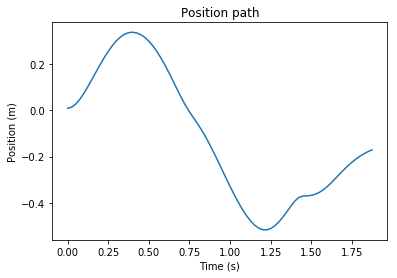

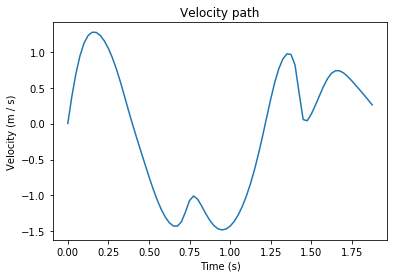

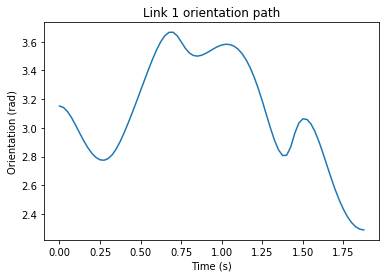

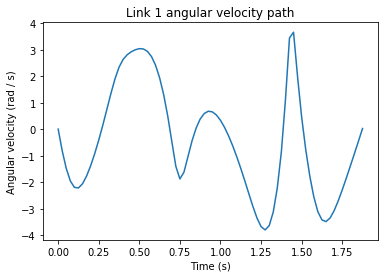

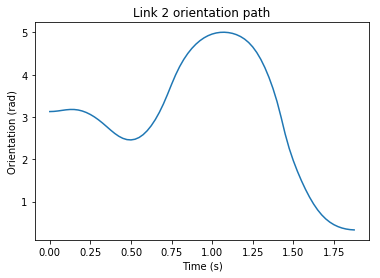

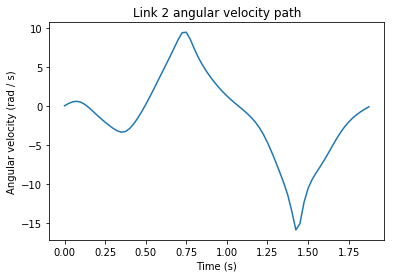

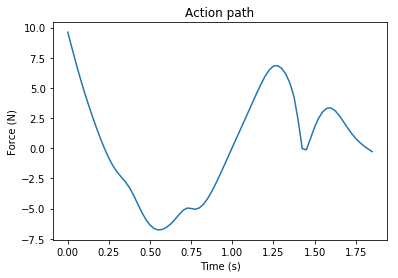

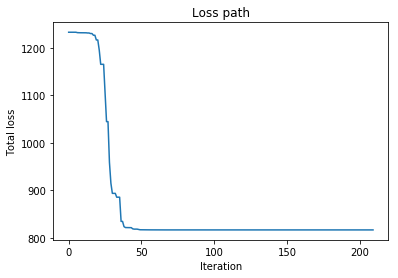

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


SyntaxError: unexpected EOF while parsing (<string>, line 0)

In [ ]:
Z = torch.empty(H + 1, Z.shape[-1])
U = torch.empty(H, model.action_size)
Z[0] = env.get_state().encode(ENCODING)
for i in range(H):
    U[i] = controller(Z[i], i, ENCODING, mpc=True, u_min=U_MIN, u_max=U_MAX, on_iteration=on_iteration)
    env.apply(U[i])
    Z[i + 1] = env.get_state().encode(ENCODING)
env.reset()

iteration 1 iLQRState.ACCEPTED 501.8334 [ 0.07840868 -0.19448496 -1.1453546   0.3342421  -0.08882792  0.09227493]
iteration 2 iLQRState.ACCEPTED 549.4084 [ 0.06174917 -0.44263577 -1.1724061  -0.6823616  -0.10670168  0.02442649]
iteration 3 iLQRState.ACCEPTED 814.1529 [ 0.03479579 -0.6894052  -1.2197665  -1.6706913  -0.11254627 -0.14983968]
iteration 4 iLQRState.ACCEPTED 1201.18 [-0.12368343 -0.60506475 -1.5770515  -2.3439956  -0.15020257 -0.53598547]
iteration 5 iLQRState.REJECTED 1893.5098 [-0.15677677 -0.7068186  -1.7157491  -3.196884   -0.19829446 -1.4474859 ]
iteration 5 iLQRState.REJECTED 1893.5098 [-0.15677677 -0.7068186  -1.7157491  -3.196884   -0.19829446 -1.4474859 ]
iteration 5 iLQRState.REJECTED 1893.5098 [-0.15677677 -0.7068186  -1.7157491  -3.196884   -0.19829446 -1.4474859 ]
iteration 5 iLQRState.REJECTED 1893.5098 [-0.15677677 -0.7068186  -1.7157491  -3.196884   -0.19829446 -1.4474859 ]
iteration 5 iLQRState.REJECTED 1893.5098 [-0.15677677 -0.7068186  -1.7157491  -3.1968

iteration 36 iLQRState.ACCEPTED 3037.1357 [-0.6885478   0.97053355 -2.3740234   1.4208478   0.28904667  1.8029728 ]
iteration 37 iLQRState.ACCEPTED 2663.636 [-0.5911673   1.3139124  -2.1566045   0.37068212  0.49047795  1.7126575 ]
iteration 38 iLQRState.ACCEPTED 2706.865 [-0.6061606  1.5195552 -2.0609205 -0.6612228  0.7778906  1.7595701]
iteration 39 iLQRState.REJECTED 3057.4756 [-0.5214929   1.8846554  -2.1251652  -1.9101899   0.85677093  1.4276432 ]
iteration 39 iLQRState.REJECTED 3057.4756 [-0.5214929   1.8846554  -2.1251652  -1.9101899   0.85677093  1.4276432 ]
iteration 39 iLQRState.REJECTED 3057.4756 [-0.5214929   1.8846554  -2.1251652  -1.9101899   0.85677093  1.4276432 ]
iteration 39 iLQRState.REJECTED 3057.4756 [-0.5214929   1.8846554  -2.1251652  -1.9101899   0.85677093  1.4276432 ]
iteration 39 iLQRState.REJECTED 3057.4756 [-0.5214929   1.8846554  -2.1251652  -1.9101899   0.85677093  1.4276432 ]
iteration 39 iLQRState.ACCEPTED 2969.1333 [-0.7269057  1.6483772 -2.0981534 -1.6

In [ ]:
plot(Z, U)

In [ ]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

In [ ]:
for i in range(10):
    env.apply(torch.zeros(model.action_size))

In [ ]:
env.close()